In [1]:
import mrcfile

In [2]:
name = "TS_0003"

In [ ]:
import numpy as np
# names = [f"TS_000{i}" for i in range(1, 10)] + ["TS_0010"]
names = ["TS_026", "TS_030", "TS_034", "TS_037", "TS_041"]
for name in names:
    print(name)
    s = mrcfile.read(f"/mnt/hdd_pool_zion/userdata/diyor/data/deepict/DEF/tomograms/{name}_trimmed.rec")
    print(s.dtype)
    s = s.astype(np.float32)
    s = (s - s.mean()) / s.std()
    # print(s.dtype)
    mrcfile.write(f"/mnt/hdd_pool_zion/userdata/diyor/data/deepict/DEF/tomograms_normalized/{name}_trimmed.rec", s)
# g = mrcfile.read(f"/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/labels/{name}_membranes_trimmed.mrc")

TS_0001
TS_0002
TS_0003
TS_0004
TS_0005
TS_0006
TS_0007
TS_0008
TS_0009
TS_0010


In [4]:
s.mean()

1.52239850313782

In [5]:
s.std()

21.061750503383365

In [21]:
s.shape

(240, 927, 959)

In [22]:
import matplotlib.pyplot as plt
# plt.imshow(s[120], cmap='gray')
plt.imsave("plots/vpp_gt_example.png", g[120], cmap='gray')

In [9]:
s.shape

(240, 927, 959)

In [ ]:
assert s.shape[0] == g.shape[0] and s.shape[1] == g.shape[1] and s.shape[2] == g.shape[2]

AssertionError: 

In [16]:
g.shape

(200, 927, 927)

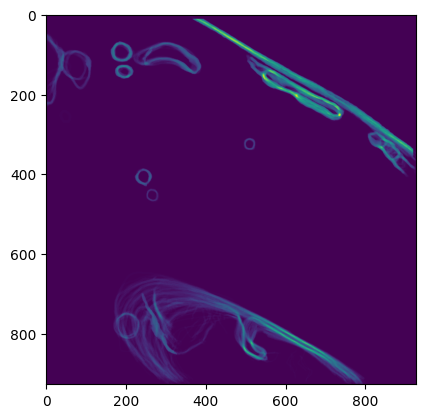

In [18]:
import matplotlib.pyplot as plt
plt.imshow(g.sum(axis=0))

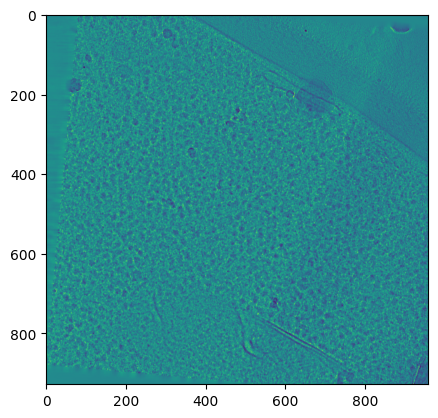

In [19]:
plt.imshow(s.sum(axis=0))

In [6]:
from datasets import build_dataset
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="configs/"):
    cfg = compose(config_name='config.yaml')

print(cfg)
OmegaConf.set_struct(cfg, False)
cfg = OmegaConf.merge(cfg, cfg.method)


{'exp_name': 'def-vpp-003', 'ckpt_path': '/workspaces/cryo/cryo-ttt/src/ttt_ckpt/denoiseg-gn-def-b6e1b/epoch=319-val/dice_loss=0.45.ckpt', 'seed': 42, 'debug': False, 'devices': [1, 2], 'load_num_workers': 48, 'pin_memory': False, 'persistent_workers': True, 'log_every_n_steps': 1, 'method': {'model_name': 'denoiseg', 'train_batch_size': 8, 'eval_batch_size': 10, 'test_batch_size': 1, 'dataset': 'denoiseg', 'mask_ratio': 0.1, 'window_size': 5, 'depth': 2, 'initial_features': 4, 'encoder_dropout': 0.0, 'decoder_dropout': 0.1, 'BN': 'group_norm', 'elu': False, 'learning_rate': 0.003, 'decay_milestones': [], 'decay_gamma': 1.0, 'max_epochs': 400, 'grad_clip_norm': None, 'train_data_root_dir': '/mnt/hdd_pool_zion/userdata/diyor/data/deepict/training/12-12-trimmed-256-b20/work/testing_data/def_train', 'val_data_root_dir': '/mnt/hdd_pool_zion/userdata/diyor/data/deepict/training/12-12-trimmed-256-b20/work/testing_data/def_train/030', 'test_data_root_dir': '/media/ssd3/diyor/23-01-deepict-256

In [7]:
ds = build_dataset(cfg, test=True)
print(ds.root_dir)

/media/ssd3/diyor/23-01-deepict-256-clean/work/training_data/vpp/003


In [8]:
import torch
labs = []
ids = []
for elem in ds:
    img = torch.Tensor(elem["image"])
    lab = torch.Tensor(elem["label"])
    id = elem["id"]
    id = id.split("_")[-1]
    id = id[1:-1].split(" ")
    id = [int(elem) for elem in id]
    # print(id)
    ids.append(id)
    # labs.append(lab)
    break
    # break

In [10]:
img.std()

tensor(19.9903)

In [79]:
import numpy as np

def reassemble_subtomograms(sub_tomograms, centers, original_shape, d):
    """
    Reassemble the predicted segmentation masks from sub-tomograms into the original tomogram shape.

    Args:
        sub_tomograms (list of numpy.ndarray): List of sub-tomogram predictions (binary, single-channel).
        centers (list of list of int): List of center coordinates for each sub-tomogram.
        original_shape (tuple of int): Shape of the original tomogram (X, Y, Z).
        d (int): Size of each sub-tomogram (d, d, d).

    Returns:
        numpy.ndarray: Reassembled tomogram of shape `original_shape`.
    """
    # Initialize arrays for reassembled mask and normalization counts
    reassembled_mask = np.zeros([elem + 24 for elem in original_shape], dtype=np.float32)
    normalization_count = np.zeros([elem + 24 for elem in original_shape], dtype=np.float32)

    half_d = d // 2  # Half size of the sub-tomogram

    for sub_tomogram, center in zip(sub_tomograms, centers):
        # Calculate the bounds of the sub-tomogram in the original tomogram space
        start_x = max(center[0] - half_d, 0)
        start_y = max(center[1] - half_d, 0)
        start_z = max(center[2] - half_d, 0)
        end_x = min(center[0] + half_d, original_shape[0])
        end_y = min(center[1] + half_d, original_shape[1])
        end_z = min(center[2] + half_d, original_shape[2])

        # Calculate the corresponding region in the sub-tomogram
        # sub_start_x = half_d - (center[0] - start_x)
        # sub_start_y = half_d - (center[1] - start_y)
        # sub_start_z = half_d - (center[2] - start_z)
        sub_start_x = 0
        sub_start_y = 0
        sub_start_z = 0
        sub_end_x = sub_start_x + (end_x - start_x)
        sub_end_y = sub_start_y + (end_y - start_y)
        sub_end_z = sub_start_z + (end_z - start_z)

        # Add the sub-tomogram values to the reassembled mask
        reassembled_mask[start_x:end_x, start_y:end_y, start_z:end_z] += sub_tomogram[
            sub_start_x:sub_end_x, sub_start_y:sub_end_y, sub_start_z:sub_end_z
        ]

        # Increment the normalization count for the overlapping regions
        normalization_count[start_x:end_x, start_y:end_y, start_z:end_z] += 1

    # Normalize the reassembled mask to account for overlapping regions
    normalization_count[normalization_count == 0] = 1  # Avoid division by zero
    reassembled_mask /= normalization_count

    # Threshold to obtain binary segmentation (optional, if required)
    reassembled_mask = (reassembled_mask > 0.5).astype(np.uint8)

    return reassembled_mask[12: reassembled_mask.shape[0] - 12, 12: reassembled_mask.shape[1] - 12, 12: reassembled_mask.shape[2] - 12]

In [22]:
labs = [elem.squeeze(0).numpy() for elem in labs]

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [80]:
a = reassemble_subtomograms(labs, ids, (240, 927, 959), 256)

In [ ]:
a

In [24]:
a.shape

(240, 927, 959)

In [5]:
labs = torch.stack(labs, dim=0)

In [6]:
labs.shape

torch.Size([15, 1, 256, 256, 256])

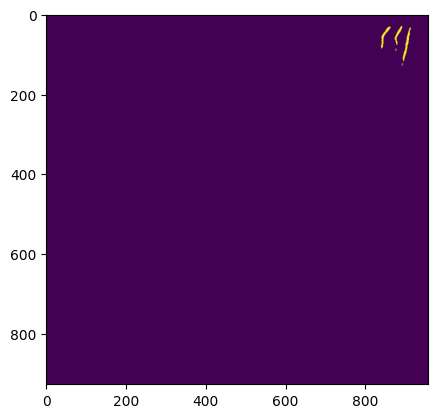

In [71]:
import matplotlib.pyplot as plt
plt.imshow(a[0])

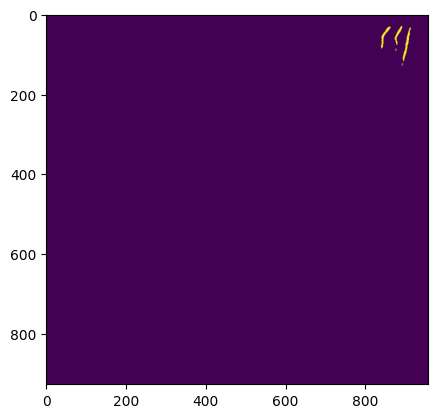

In [72]:
plt.imshow(g[0])

In [81]:
for i in range(240):
    if not np.all(a[0] == g[0]):
        print("fref")

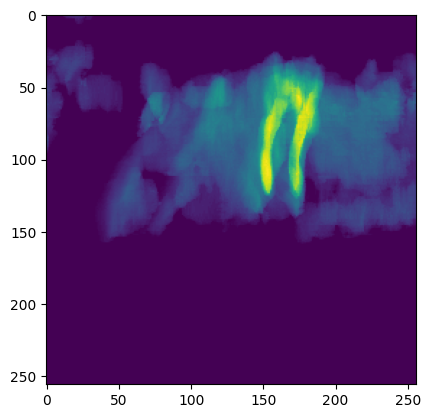

In [61]:
plt.imshow(labs[1].sum(axis=1))

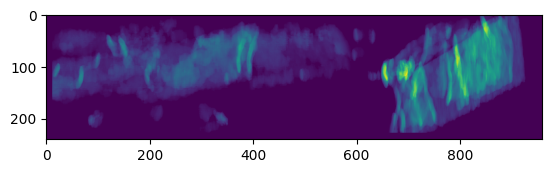

In [70]:
plt.imshow(a.sum(axis=1))

In [68]:
a_shape = a.shape
a = a[12: a_shape[0] - 12, 12: a_shape[1] - 12, 12: a_shape[2] - 12]

In [69]:
a.shape

(240, 927, 959)

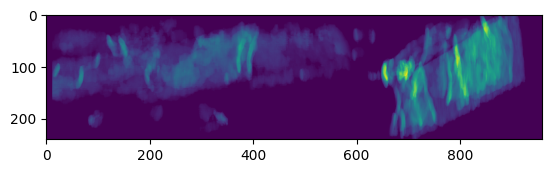

In [67]:
plt.imshow(g.sum(axis=1))

In [59]:
for i in range(0, 240):
    # if np.all(g[120] == a[i]):
    print((g[120] == a[i]).sum() / a[i].size)

0.9585384811803918
0.9587117108908619
0.958868067577585
0.9590750433355493
0.959175156609782
0.9592673958062662
0.9593236392187565
0.9594586234087332
0.9594957440609768
0.959523865767222
0.9595913578622104
0.9596498510112003
0.9596880965316937
0.9596498510112003
0.9595913578622104
0.959523865767222
0.9594957440609768
0.9594586234087332
0.9593236392187565
0.9592673958062662
0.959175156609782
0.9590750433355493
0.958868067577585
0.9587117108908619
0.9585384811803918
0.9583225064764289
0.9580266661267299
0.9577634469562752
0.9572955017643558
0.9568736761706785
0.956203254693794
0.9557341846336248
0.9552808627289529
0.9548140424052833
0.9541278727729015
0.9536048090367416
0.9532009813350611
0.9526610445751541
0.9519973723077685
0.9512549592628964
0.950357314399551
0.9495440346549411
0.9484799092906243
0.9476857523062612
0.9468657233521524
0.9461626806960235
0.9453167797721692
0.9446407339540356
0.9440951728528796
0.9434854942614846
0.9426024726853868
0.9417633209710312
0.9409624147771692
0

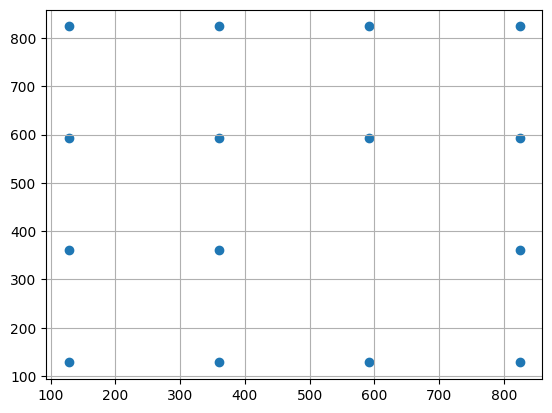

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x_coords, y_coords)
plt.grid()
plt.show()

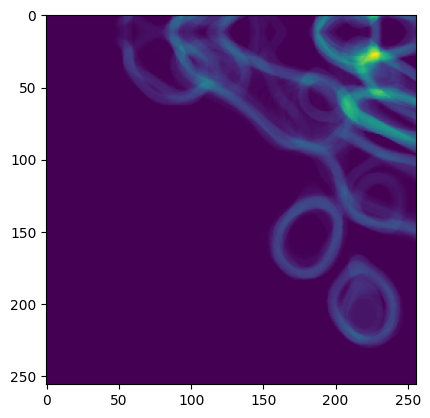

In [4]:
import matplotlib.pyplot as plt

plt.imshow(lab[0].sum(axis=0))

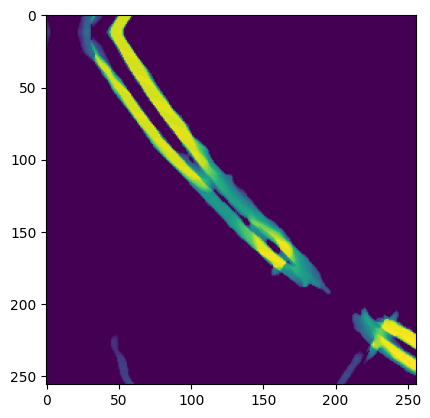

In [18]:
import torchvision.transforms.functional as FT
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# im = Image.fromarray(img[0].sum(axis=0).numpy().astype(np.int8), "L")
im = FT.to_pil_image(lab[0].sum(axis=0).unsqueeze(0).to(torch.uint8), mode="L")
plt.imshow(im)

In [19]:
np.array(im).shape

(256, 256)

In [21]:
lab.shape
from utils.colormaps import grayscale_to_viridis

im_v = grayscale_to_viridis(lab[0].sum(axis=0))

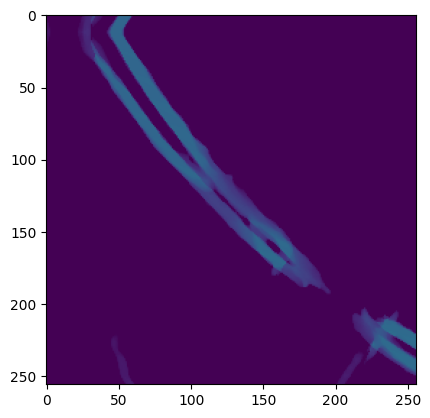

In [25]:
plt.imshow(im_v)

In [23]:
np.array(im_v).shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007450980392156863..1.0580392156862746].


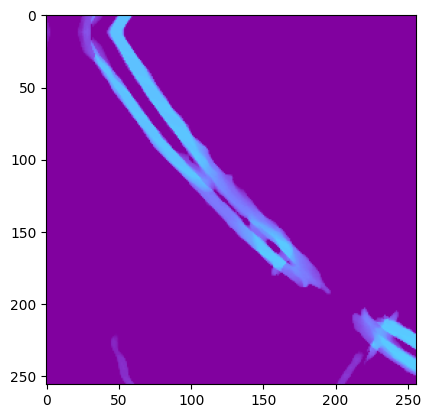

In [33]:
plt.imshow(np.array(im_v) * 1.9 / 255)

plt.imshow(img[0, 128])

In [12]:
img_pil = FT.to_pil_image(img[0, 128].numpy(), mode="F")
plt.imshow(img_pil)

NameError: name 'FT' is not defined

In [22]:
lab.dtype

torch.float32

In [3]:
import mrcfile
g = mrcfile.read(f"/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/labels/TS_0001_membranes_trimmedX.mrc")

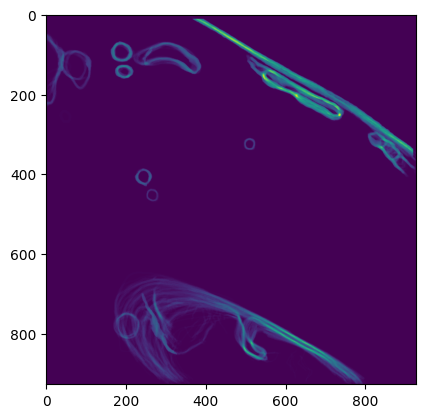

In [4]:
import matplotlib.pyplot as plt
plt.imshow(g.sum(axis=0))

In [5]:
import numpy as np

g_rot = np.rot90(g, k=1, axes=(1,2))

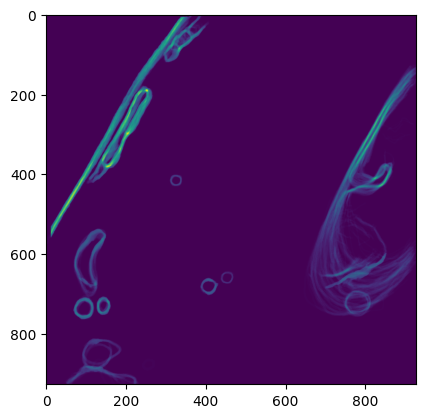

In [6]:
plt.imshow(g_rot.sum(axis=0))

In [1]:
from membrain_seg.benchmark.compute_stats import compute_stats

dir_gt = "/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/labels"
dir_pred = "/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/membrain_out/TS_0003_MemBrain_seg_v10_alpha.ckpt_segmented.mrc"
out_dir = "/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/membrain_out"
out_file_token = "stats"

compute_stats(dir_gt, dir_pred, out_dir, out_file_token)

NotADirectoryError: [Errno 20] Not a directory: '/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/labels/TS_0003_membranes.mrc'

In [1]:
import mrcfile
pred = mrcfile.read("/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/membrain_out/TS_0003_trimmed_MemBrain_seg_v10_alpha.ckpt_segmented.mrc")
gt = mrcfile.read("/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/labels/TS_0003_membranes_trimmed.mrc")

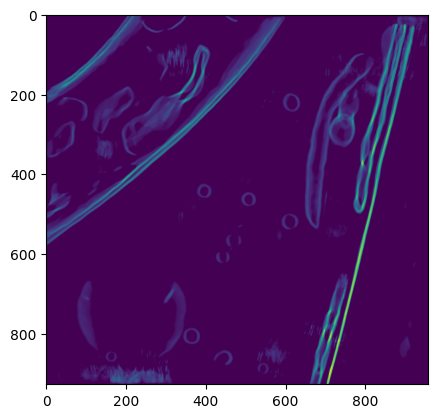

In [3]:
import matplotlib.pyplot as plt
plt.imshow(pred.sum(axis=0))

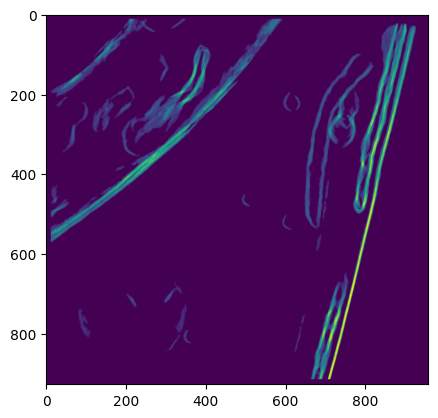

In [4]:
plt.imshow(gt.sum(axis=0))

In [4]:
import numpy as np
np.unique(pred)

array([0, 1], dtype=int8)

In [11]:
pred.shape

(1000, 927, 959)

In [2]:
from monai.metrics import DiceMetric
import torch
scoring_fn = DiceMetric()

scoring_fn(torch.Tensor(pred)[None, None, ...], torch.Tensor(gt)[None, None, ...])

tensor([[0.7319]])

In [5]:
intersection = np.logical_and(pred, gt)

2. * intersection.sum() / (gt.sum() + pred.sum())


0.7318646884731433